# Курсовая работа
## Датасет: [Facial Expression Recognition](https://paperswithcode.com/dataset/fer2013)
### Выполнил Попов Матвей, группа М8О-114СВ-24


## О датасете

Используется для задач распознавания эмоций по лицам. Содержит 35887 
изображений лиц, которые распределены на 7 категорий эмоций:

* Angry (злой)
* Disgust (отвращение)
* Fear (страх)
* Happy (счастье)
* Sad (грусть)
* Surprise (удивление)
* Neutral (нейтральное выражение)

Каждое изображение черно-белое, разрешение 48x48 пикселей. Датасет представлен 
в формате csv и состоит из 2 колонок: эмоция (число от 0 до 6) и пиксели 
(строка с интенсивностями пикселей от 0 до 255, разделенных пробелами).


Подключаем необходимые импорты

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import gdown


Загружаем датасет

In [14]:
in_google_drive = True
if in_google_drive:
    file_id = '1CjocZsoQJ_2ROD9p6KOeUxifKBnGjTsa'
    url_templ = 'https://drive.google.com/uc?export=download&id='

    local_file_name = 'fer2013.csv'
    gdown.download(url_templ + file_id, local_file_name, False)

data = pd.read_csv('fer2013.csv')

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1CjocZsoQJ_2ROD9p6KOeUxifKBnGjTsa
From (redirected): https://drive.google.com/uc?export=download&id=1CjocZsoQJ_2ROD9p6KOeUxifKBnGjTsa&confirm=t&uuid=10f7e23d-15c9-49b8-88c4-4fc16c5d023a
To: /Users/papey08/prog/mai_aif/fer2013.csv
100%|██████████| 301M/301M [00:46<00:00, 6.46MB/s] 


Выведем структуру датасета

In [15]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Инициализируем список эмоций

In [16]:
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

Выведем изображение из датасета

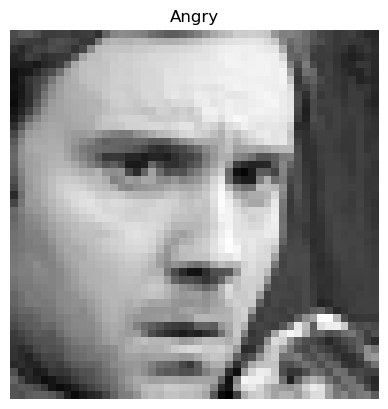

In [17]:
def plot_images(data):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    pixels = np.array(data.iloc[0, 1].split(), dtype='float32').reshape(48, 48)
    emotion = emotions[data.iloc[0, 0]]
    plt.imshow(pixels, cmap="gray")
    plt.title(emotion)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_images(data)


Выведем распределение лиц по эмоциям

Распределение лиц по категориям эмоций
Всего: 35887
Happy: 8989 (25.05%)
Neutral: 6198 (17.27%)
Sad: 6077 (16.93%)
Fear: 5121 (14.27%)
Angry: 4953 (13.80%)
Surprise: 4002 (11.15%)
Disgust: 547 (1.52%)


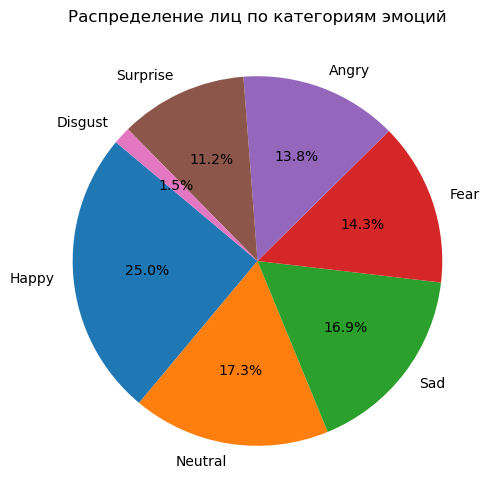

In [18]:
def emotion_distribution(data, emotions):
    emotion_counts = data['emotion'].value_counts()
    total = len(data)

    print('Распределение лиц по категориям эмоций')
    print(f'Всего: {total}')
    for i, count in emotion_counts.items():
        persentage = (count / total) * 100
        print(f'{emotions[i]}: {count} ({persentage:.2f}%)')
    
    emotion_percentages = (emotion_counts / total) * 100
    plt.figure(figsize=(8, 6))
    plt.pie(
        emotion_percentages, 
        labels=[emotions[i] for i in emotion_percentages.index], 
        autopct="%1.1f%%", 
        startangle=140, 
        colors=plt.cm.tab10.colors
    )
    plt.title('Распределение лиц по категориям эмоций')
    plt.show()

emotion_distribution(data, emotions)


## Обучение модели

Разделяем на обучающую и тестовую выборки

In [19]:
X = np.array([np.fromstring(pixels, dtype=int, sep=' ').reshape(48, 48, 1) for pixels in data["pixels"]]) / 255.0
y = to_categorical(data["emotion"], num_classes=7)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Создаем модель

In [20]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(emotions), activation='softmax')  # 7 классов эмоций
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Обучаем модель

In [22]:
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1)

Epoch 1/15
404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.2951 - loss: 1.7366 - val_accuracy: 0.4072 - val_loss: 1.5395
Epoch 2/15
404/404 ━━━━━━━━━━━━━━━━━━━━ 29s 71ms/step - accuracy: 0.4113 - loss: 1.5200 - val_accuracy: 0.4650 - val_loss: 1.4116
Epoch 3/15
404/404 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.4581 - loss: 1.4095 - val_accuracy: 0.4702 - val_loss: 1.3628
Epoch 4/15
404/404 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.4838 - loss: 1.3479 - val_accuracy: 0.4918 - val_loss: 1.3295
Epoch 5/15
404/404 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.5053 - loss: 1.2895 - val_accuracy: 0.5172 - val_loss: 1.2793
Epoch 6/15
404/404 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.5213 - loss: 1.2546 - val_accuracy: 0.5225 - val_loss: 1.2685
Epoch 7/15
404/404 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.5449 - loss: 1.1931 - val_accuracy: 0.5329 - val_loss: 1.2482
Epoch 8/15
404/404 ━━━━━━━━━━━━━━━━━━━━ 32s 78ms/step - accuracy: 0.5609 - loss: 1.1584 - 

Результаты обучения

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5533 - loss: 1.2051
Точность на тестовых данных: 55.54%


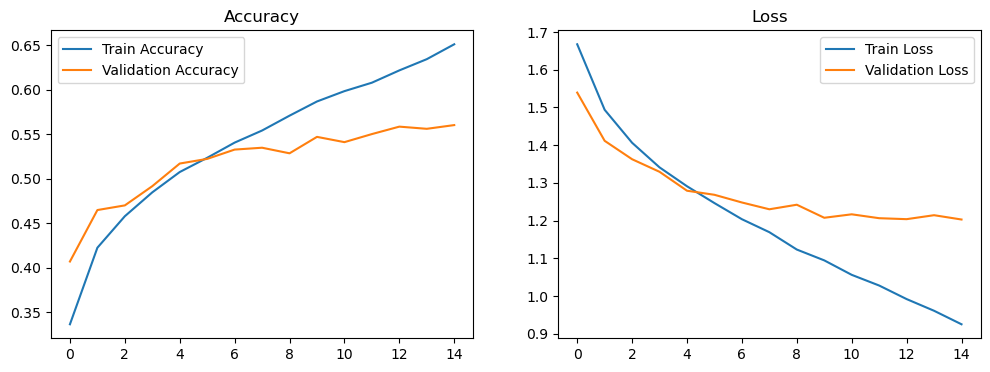

In [32]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Точность на тестовых данных: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Примеры использования модели

Функция для получения фото из файла и предсказания эмоции

In [24]:
def predict_emotion_from_file(image_path, model, emotions):
    img = Image.open(image_path).convert('L')
    img = img.resize((48, 48))
    img_array = np.array(img).reshape(1, 48, 48, 1) / 255.0
    
    prediction = model.predict(img_array)
    predicted_emotion = emotions[np.argmax(prediction)]
    
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted Emotion: {predicted_emotion}")
    plt.axis('off')
    plt.show()
    
    return predicted_emotion


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


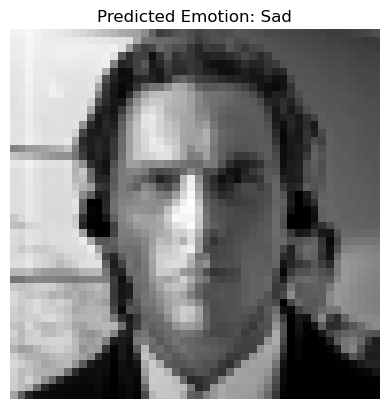

'Sad'

In [29]:
predict_emotion_from_file('img/patrick_bateman.jpg', model, emotions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


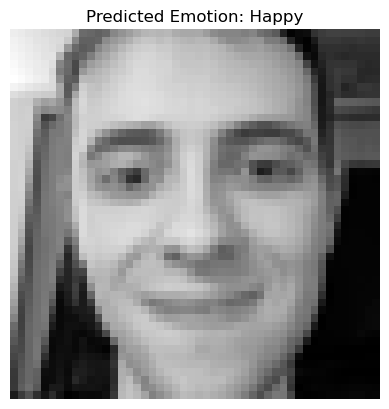

'Happy'

In [30]:
predict_emotion_from_file('img/happy_matvey_popov.jpg', model, emotions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


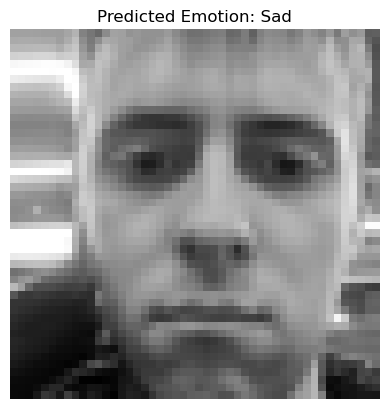

'Sad'

In [31]:
predict_emotion_from_file('img/sad_matvey_popov.jpg', model, emotions)

## Вывод

Решил задачу классификации эмоций человека на фотографиях. Точность на тестовых 
данных – 0.56
